In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm

/Users/Peter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df = pd.read_csv('../../dataSandbox/forPelican/nbaWiggins.csv')

In [3]:
allShots = df[np.invert(np.isnan(df.SHOT_CLOCK))]
cMin,cSec = allShots.loc[:,'GAME_CLOCK'].str.split(':').str.get(0),allShots.loc[:,'GAME_CLOCK'].str.split(':').str.get(1)
allShots.loc[:,'secGameClock'] = cMin.astype('int') * 60 + cSec.astype('int')

/Users/Peter/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Peter/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Dummify variables

In [4]:
pd.get_dummies(allShots[['W','LOCATION','FGM']])
allShots.loc[:,'gameWon'] = pd.get_dummies(allShots['W'])['W']
allShots.loc[:,'homeGame'] = pd.get_dummies(allShots['LOCATION'])['H']
allShots.loc[:,'is3Pointer'] = pd.get_dummies(allShots['PTS_TYPE'])[3]
q = pd.get_dummies(allShots['PERIOD'])[[2,3,4,5]]
q.columns = ['q' + str(i) for i in q.columns]
allShots = pd.concat([allShots,q],axis=1)

### Clean up

In [5]:
dropThese = ['GAME_ID','MATCHUP','CLOSEST_DEFENDER','CLOSEST_DEFENDER_PLAYER_ID','GAME_CLOCK','SHOT_RESULT','LOCATION','W','PERIOD','PTS_TYPE','PTS']
[ allShots.drop(i, axis=1, inplace=True) for i in dropThese ] 

[None, None, None, None, None, None, None, None, None, None, None]

### Import learning algorithms

In [6]:
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn import cross_validation
from sklearn.preprocessing import scale, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

### Split the data

In [7]:
trainShots = allShots[1::2] #Odd rows
testShots = allShots[::2] #Even rows

### Scale the data
Some algorithms are scale invariant, but others aren't. So scale the data for the appropriate algorithms

### Pluribus machina
Now, we will build a series of function to test machine learning algorithms head-to-head. First, a generalized function to run each learning algorithm.

In [8]:
def runLearning(myData,myMod,trainIdx,testIdx,respVar,scaleIt=False,printMe=False): #Make this a function of train/test set, scale, algorithm
    predCol = [col for col in myData.columns if col != respVar]
    if scaleIt == True:
        myData = pd.DataFrame(scale(myData), index=myData.index, columns=myData.columns)
    #else:
    #    myData = pd.DataFrame(scale(myData, with_std=False), index=myData.index, columns=myData.columns)
    trainSet = eval('myData' + trainIdx).astype(float)
    testSet = eval('myData' + testIdx).astype(float)
    myEst = eval(myMod)
    # Need to binarize data or it will break
    trainResp = trainSet[respVar].astype(float)
    trainResp.ix[trainResp > 0] = 1
    trainResp.ix[trainResp <= 0] = 0
    myEst.fit(
        trainSet[predCol],
        trainResp
    )
    # Need to binarize data or it will break
    testResp = testSet[respVar].astype(float)
    testResp.ix[testResp > 0] = 1
    testResp.ix[testResp <= 0] = 0
    matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testResp)
    testLen = testSet.shape[0]
    if(printMe==True):
        print 'Algorithm used:\n' + myMod + '    scaled=' + str(scaleIt)
        print "Correctly classified:\n" + str(round(float(matches) / testLen * 100,2)) + '%\n\n'
    else:
        return round(float(matches) / testLen * 100,2)

In [9]:
runLearning(myData=allShots,myMod='RandomForestClassifier(n_estimators=100)',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 
runLearning(myData=allShots,myMod='BaggingClassifier()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 
    
#myLearning(myData=allShots,myMod='SGDClassifier(alpha=2)',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 
#myLearning(myData=allShots,myMod='RidgeClassifier(alpha=2)',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 
#myLearning(myData=allShots,myMod='SVC()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 
#myLearning(myData=allShots,myMod='SVC()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=True,printMe=True)
#myLearning(myData=allShots,myMod='LogisticRegression()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=True,printMe=True) 
#myLearning(myData=allShots,myMod='LogisticRegression()',trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=False,printMe=True) 

Algorithm used:
RandomForestClassifier(n_estimators=100)    scaled=False
Correctly classified:
63.16%


Algorithm used:
BaggingClassifier()    scaled=False
Correctly classified:
60.62%




In [10]:
dfPred = pd.DataFrame(columns=['algorithm','accuracy','scaled'])

algs = ['RandomForestClassifier(n_estimators=100)','BaggingClassifier()','SGDClassifier(alpha=2)','RidgeClassifier(alpha=2)','SVC()','LogisticRegression()']
myScale = ['False','False','False','False','True','False']

for i in range(len(algs)):
    # Calculate prediction algorithm for scaled/non-scaled data in each algorithm
    temp1 = runLearning(myData=allShots,myMod=algs[i],trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=myScale[i])
    algName = algs[i]
    algName = algName.split('(')[0]
    dfPred = dfPred.append({'algorithm': algName, 'accuracy': temp1, 'scaled': myScale[i]}, ignore_index = True)
    
dfPred

,algorithm,accuracy,scaled
0,RandomForestClassifier,63.52,False
1,BaggingClassifier,59.35,False
2,SGDClassifier,52.09,False
3,RidgeClassifier,60.62,False
4,SVC,54.63,True
5,LogisticRegression,60.25,False


In [11]:
dfPred = pd.DataFrame(columns=['algorithm','accuracy','scaled'])

algs = ['RandomForestClassifier(n_estimators=100)','BaggingClassifier()','SGDClassifier(alpha=2)','RidgeClassifier(alpha=2)','SVC()','LogisticRegression()']
myScale = ['False','False','False','False','True','False']

# Calculate prediction accuracy for each algorithm
for i in range(len(algs)):
    for j in range(200):    # Sample 200 times to get 95%CI
        temp1 = runLearning(myData=allShots,myMod=algs[i],trainIdx='[1::2]',testIdx='[::2]',respVar='FGM',scaleIt=myScale[i])
        algName = algs[i]
        algName = algName.split('(')[0]
        dfPred = dfPred.append({'algorithm': algName, 'accuracy': temp1, 'scaled': myScale[i]}, ignore_index = True)
    
dfPred.head()

,algorithm,accuracy,scaled
0,RandomForestClassifier,62.98,False
1,RandomForestClassifier,63.34,False
2,RandomForestClassifier,62.79,False
3,RandomForestClassifier,61.52,False
4,RandomForestClassifier,63.88,False


In [12]:
def get95CI(df,alg):
    temp = df.loc[dfPred.algorithm==alg]
    temp = temp.sort_values(by='accuracy').reset_index(drop=True)
    temp
    mean = np.mean(temp.accuracy)  # mean
    low95 = mean - temp.ix[4,'accuracy']   # low95
    hi95 = temp.ix[194,'accuracy'] - mean # high95
    return mean, low95, hi95

In [13]:
def getAlgStatSummary(df, alg):
    algStats = get95CI(df, alg)
    df = pd.DataFrame(columns=['algorithm', 'mean', 'low95', 'high95'])
    df = df.append({'algorithm': alg, 'mean': algStats[0], 'low95': algStats[1], 'high95': algStats[2]}, ignore_index = True)
    return df
    
getAlgStatSummary(dfPred,'RandomForestClassifier')

,algorithm,mean,low95,high95
0,RandomForestClassifier,62.56955,2.12955,2.22045


In [14]:
dfStats = pd.DataFrame(columns=['algorithm', 'mean', 'low95', 'high95'])
for i in  list(set(dfPred.algorithm)):
    dfStats = dfStats.append(getAlgStatSummary(dfPred,i),ignore_index=True)
dfStats = dfStats.sort_values('mean')
dfStats

,algorithm,mean,low95,high95
4,SGDClassifier,53.05365,6.953650e+00,8.656350e+00
3,SVC,54.63000,-1.421085e-13,1.421085e-13
2,BaggingClassifier,59.83510,3.215100e+00,2.774900e+00
0,LogisticRegression,60.25000,0.000000e+00,0.000000e+00
5,RidgeClassifier,60.62000,1.918465e-13,-1.918465e-13
1,RandomForestClassifier,62.56955,2.129550e+00,2.220450e+00


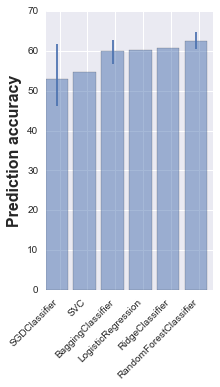

In [15]:
fig = plt.figure(figsize=(3,5), dpi=1600)
ax = plt.subplot(111)

barPlot = plt.bar(range(6),dfStats.loc[:,'mean'],yerr=[list(dfStats.loc[:,'low95']),list(dfStats.loc[:,'high95'])],alpha=0.5)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in barPlot]
plt.xticks([i+0.5 for i in range(6)],dfStats.loc[:,'algorithm'],rotation=45,ha='right')
ax.set_ylabel('Prediction accuracy',fontsize=16,fontweight='bold')


In [16]:
### Lastly, I want to figure out which variables are most important in prediction

In [17]:
#Function to find the best C value

def findC(cVal):
    tempData = allShots
    trainSet = eval('tempData' + '[1::2]').astype(float)
    testSet = eval('tempData' + '[::2]').astype(float)
    
    myEst = LogisticRegression(C=cVal)
    predCol = [col for col in allShots.columns if col != 'FGM']
    predVar = trainSet['FGM'].astype(float)
    predVar.ix[predVar>0]=1
    predVar.ix[predVar<=0]=0
    myEst.fit(
        X=trainSet[predCol],
        y=predVar
    )


    testVar = testSet['FGM'].astype(float)
    testVar.ix[testVar>0]=1
    testVar.ix[testVar<=0]=0
    matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testVar)
    return matches/float(len(testSet))*100
    #return matches

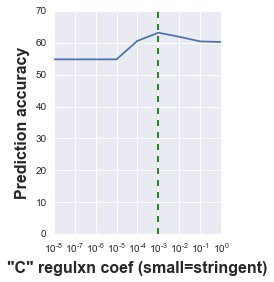

In [18]:
fig = plt.figure(figsize=(3,4), dpi=1600)
ax = plt.subplot(111)

cList=[]
for i in [np.power(10,float(i)) for i in np.arange(0,-9,-1)]:
    cList.append(findC(i))
    
cList
plt.plot([np.power(10,float(i)) for i in np.arange(0,-9,-1)],cList)
ax.set(xscale="log")
ax.set_ylim([0,70])
plt.plot((0.001, 0.001), (0, 70), 'g--')
ax.set_xlabel('"C" regulxn coef (small=stringent)',fontsize=16,fontweight='bold')
ax.set_ylabel('Prediction accuracy',fontsize=16,fontweight='bold')

In [19]:
tempData = allShots

trainSet = eval('tempData' + '[1::2]').astype(float)
testSet = eval('tempData' + '[::2]').astype(float)

#myEst = eval('LogisticRegression()')
myEst = LogisticRegression(C=0.001)
predCol = [col for col in allShots.columns if col != 'FGM']
predVar = trainSet['FGM'].astype(float)
predVar.ix[predVar>0]=1
predVar.ix[predVar<=0]=0
myEst.fit(
    X=trainSet[predCol],
    y=predVar
)


testVar = testSet['FGM'].astype(float)
testVar.ix[testVar>0]=1
testVar.ix[testVar<=0]=0

#matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testSet['FGM'])
#matches = np.count_nonzero(myEst.predict(testSet[predCol]) == testVar)
#myEst.predict(testSet[predCol])
#myEst.predict(testSet[predCol])
#matches
#myEst.coef_

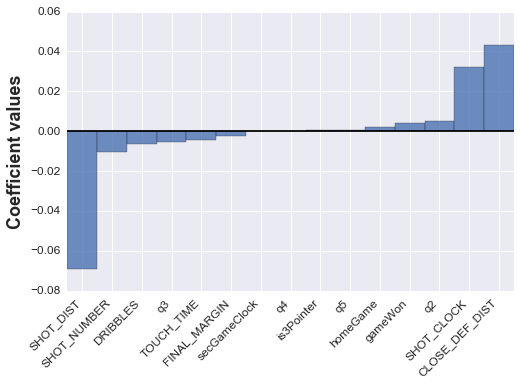

In [20]:
#myEst.coef_
logR = pd.DataFrame(myEst.coef_)
logR.columns=predCol
logR

fig = plt.figure(figsize=(8,5), dpi=1600)
ax = plt.subplot(111)


#logR.ix[logR.last_valid_index()]
logR.ix[0].argsort()
newCol = logR.columns[logR.ix[0].argsort()]
logR = logR[newCol]


sns.set_style("dark")
plt.bar(range(len(predCol)),logR.iloc[0],alpha=0.8,width=1)

plt.xticks([i+0.5 for i in range(len(predCol))],logR.columns,rotation=45,ha='right',fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('Coefficient values',fontsize=18,fontweight='bold')
plt.plot((0, 15), (0, 0), 'k-')
plt.show()

In [21]:
#working
def compareDist(myVar,myTitle,df=allShots,myHist=False):
    made = df.loc[df['FGM']==True]
    missed = df.loc[df['FGM']==False]
    sns.distplot(made[myVar],hist=myHist,label="made shots")
    sns.distplot(missed[myVar],hist=myHist,label="missed shots")
    plt.legend();
    plt.title(myTitle,fontsize=16)

In [22]:
# In development...
def compareDist(myVar,myTitle,df=allShots,myHist=False):
    made = df.loc[df['FGM'] == True]
    missed = df.loc[df['FGM']  == False]
    sns.distplot(made[myVar],hist=myHist,label="made shots")
    sns.distplot(missed[myVar],hist=myHist,label="missed shots")
    plt.legend();
    plt.title(myTitle,fontsize=16)


histHeights= [ 0.1071753   0.21071753  0.21707539  0.14804723  0.14713896  0.06993642
  0.04359673  0.02179837  0.00726612  0.00544959  0.0027248   0.00454133
  0.0027248   0.00181653  0.00090827  0.0027248   0.00454133  0.00090827
  0.00090827]
histBins= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


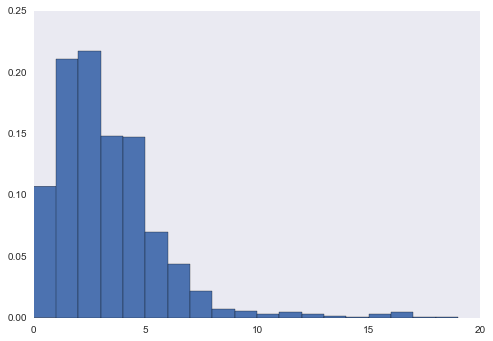

In [23]:
#np.mean(made['CLOSE_DEF_DIST'])
#plt.hist(made['CLOSE_DEF_DIST'])
#plt.hist(np.random.randn(100))
myBins = [i for i in range(20)]
histHeights, histBins, c = plt.hist(np.array(allShots['CLOSE_DEF_DIST']),normed=True,bins=myBins)
print 'histHeights= ' + str(histHeights) #+ '\n\n'
print 'histBins= ' + str(histBins) #+ '\n\n'
#print 'c= ' + str(c) #+ '\n\n'


In [24]:
#allShots.loc[allShots['gameWon']==1]
myVar='q2'
df=allShots
cond='==1'
#q2
#print 'df.loc[df["' + str(myVar) + '"]' + str(cond) + ']'
#eval('df.loc[df["' + str(myVar) + '"]' + str(cond) + ']')
#df.loc[df['q2']==1]

In [25]:
dfSub=eval('df.loc[df["' + str(myVar) + '"]' + str(cond) + ']')
made = dfSub.loc[dfSub['FGM']==True]
missed = dfSub.loc[dfSub['FGM']==False]
#missed
    #print made.head()
    #print missed.head()

#sns.distplot(made[myVar],hist=False,label="made shots")
#sns.distplot(missed[myVar],hist=False,label="missed shots")
#plt.legend();


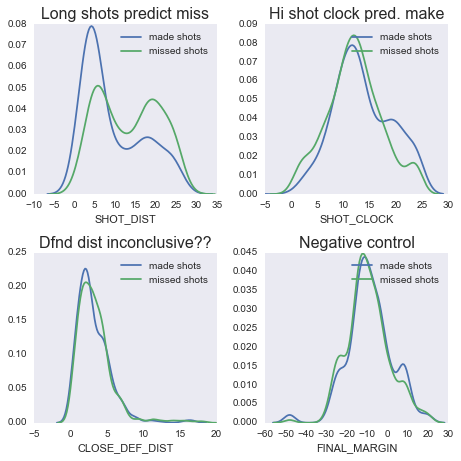

In [26]:
fig = plt.figure(figsize=(6.5,6.5), dpi=1600)
#plt.subplot(211)
plt.subplot(2,2,1)
compareDist('SHOT_DIST','Long shots predict miss')
plt.subplot(2,2,2)
compareDist('SHOT_CLOCK','Hi shot clock pred. make')
plt.subplot(2,2,3)
compareDist('CLOSE_DEF_DIST','Dfnd dist inconclusive??',myHist=False)
plt.subplot(2,2,4)
compareDist('FINAL_MARGIN','Negative control')
#compareDist('SHOT_DIST')
plt.tight_layout()

In [27]:
# This one works
def calcShootPercDist(d,myVar):
    tempDist = eval('df.loc[(df.' + str(myVar) + ' > d) & (df.' + str(myVar) + ' < (d+1))]')
    tempTotal = len(tempDist)
    tempFgm = tempDist.loc[tempDist.FGM==1]
    #tempMissed = tempDist.loc[tempDist.FGM==1]
    return len(tempFgm)/float(tempTotal)*100

In [103]:
int(np.ceil(max(allShots['SHOT_DIST'])))


28

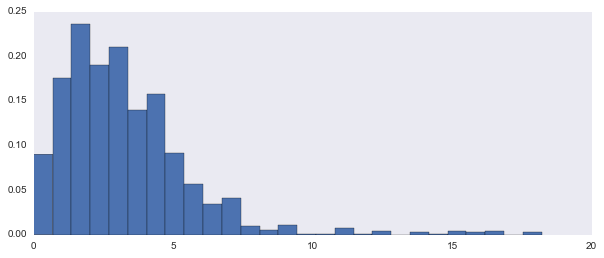

In [89]:
fig = plt.figure(figsize=(10,4), dpi=1600)

dfDefDist = pd.DataFrame(columns=['SHOT_DIST'])

myBins = [i for i in range(27)]
for i in myBins:
    madePerc = calcShootPercDist(i,'SHOT_DIST')
    dfDefDist = dfDefDist.append({'madePerc': madePerc},ignore_index=True)
    
histHeights, histBins, c = plt.hist(np.array(allShots['CLOSE_DEF_DIST']),normed=True,bins=len(myBins))
dfDefDist['density'] = histHeights

myCols = cm.RdBu(dfDefDist['density']/max(dfDefDist['density']))



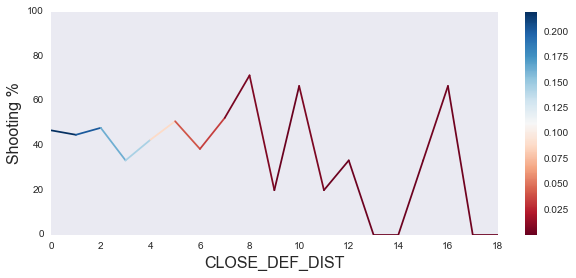

In [111]:
#Works! 
#Make as a function of myVar
myVar='SHOT_DIST'
myVar='CLOSE_DEF_DIST'
#myVar='SHOT_CLOCK'

fig = plt.figure(figsize=(10,4), dpi=1600)

maxVal = int(np.ceil(max(allShots[myVar])))
dfDefDist = pd.DataFrame(columns=['madePerc'])

myBins = [i for i in range(maxVal)]
for i in myBins:
    madePerc = calcShootPercDist(i,myVar)
    dfDefDist = dfDefDist.append({'madePerc': madePerc},ignore_index=True)
    
histHeights, histBins, c = plt.hist(np.array(allShots[myVar]),normed=True,bins=len(myBins))
dfDefDist['density'] = histHeights
#dfDefDist['density'] = dfDefDist['density']/max(dfDefDist['density'])

myCols = cm.RdBu(dfDefDist['density']/max(dfDefDist['density']))

cax = ax.imshow(dfDefDist[['density']], interpolation='nearest', cmap=cm.RdBu)
fig.clf() #clear the histogram and the `imshow` image

ax = plt.subplot(111)
ax.set_ylim(0,100)
ax.set_xlim(0,maxVal-1)

spData = dfDefDist['madePerc']
for i in range(len(spData)-1):
    plt.plot([i,i+1],[spData[i], spData[i+1]],color=([j for  j in myCols[i+1]][0:3]))

ax.set_ylabel('Shooting %',fontsize=16)
ax.set_xlabel(myVar,fontsize=16)


#cax = ax.imshow(dfDefDist[['density']], interpolation='nearest', cmap=cm.RdBu)
#fig.colorbar(cax)
plt.colorbar(cax)

plt.show()

In [ ]:

#ax.clf()
plt.show()

In [ ]:
#Works! Now just color code according to histogram heights

fig = plt.figure(figsize=(5,4), dpi=1600)
ax = plt.subplot(111)
ax.set_ylim(0,100)
ax.set_xlim(0,19)

#plt.plot(dfDefDist['madePerc'])
spData = dfDefDist['madePerc']
for i in range(len(spData)-1):
    #print spData[i], spData[i+1]
    plt.plot([i,i+1],[spData[i], spData[i+1]])

#plt.plot(x=[i,i+1],y=[spData[i], spData[i+1]])
#?plt.plot


In [ ]:
#This works
dfDefDist = pd.DataFrame(columns=['madePerc'])

distBin = np.arange(0, 19, 1)
for i in distBin:
    madePerc = calcShootPercDist(i,'SHOT_DIST')
    dfDefDist = dfDefDist.append({'madePerc': madePerc},ignore_index=True)
dfDefDist

In [ ]:

plt.plot(dfDefDist['madePerc'])


In [ ]:
def getDefDist_ShootPerc():
    print 'hi'

In [ ]:
made3 = df.loc[(df.is3Pointer==True) & (df.FGM==1)]
missed3 = df.loc[(df.is3Pointer==True) & (df.FGM==0)]

sns.distplot(made3['CLOSE_DEF_DIST'],hist=True,label="made shots")
sns.distplot(missed3['CLOSE_DEF_DIST'],hist=True,label="missed shots")

#df.loc[df['FGM']==False]

In [ ]:
made2 = df.loc[(df.is3Pointer==False) & (df.FGM==1)]
missed2 = df.loc[(df.is3Pointer==False) & (df.FGM==0)]

sns.distplot(made2['CLOSE_DEF_DIST'],hist=True,label="made shots")
sns.distplot(missed2['CLOSE_DEF_DIST'],hist=True,label="missed shots")

#df.loc[df['FGM']==False]

#### Should test if:
1. is shot% higher in OT vs 3rd quarter?
2. Is shot percentage higher in games won?

Is 3-pointer less explanatory because it is convolved into shot distance already?




In [ ]:
# Look at differences between won and lost games

won = allShots.loc[allShots['gameWon']==1]
lost = allShots.loc[allShots['gameWon']==0]

print 'Shots taken in games won:    ' + str(len(won))
print 'Shots taken in games lost:   ' + str(len(lost)) + '\n\n'

print 'Shooting percentage in games won:   ' + str(round(np.sum(won['FGM'])/float(len(won))*100,1))
print 'Shooting percentage in games lost:  ' + str(round(np.sum(lost['FGM'])/float(len(lost))*100,1))

In [ ]:
# Look at close/far defender

near = allShots.loc[allShots['CLOSE_DEF_DIST']<23]
far = allShots.loc[allShots['CLOSE_DEF_DIST']>23]

print 'Shots taken near:    ' + str(len(near))
print 'Shots taken far:   ' + str(len(far)) + '\n\n'

print 'Shooting percentage near:   ' + str(round(np.sum(near['FGM'])/float(len(near))*100,1))
print 'Shooting percentage far:  ' + str(round(np.sum(far['FGM'])/float(len(far))*100,1))

In [ ]:
# Look at 3rd quarter and OT

q1 =  allShots.loc[(allShots['q2']==0) & (allShots['q3']==0) & (allShots['q4']==0) & (allShots['q5']==0)]
q2  = allShots.loc[allShots['q2']==1]
q3  = allShots.loc[allShots['q3']==1]
q4  = allShots.loc[allShots['q4']==1]
qOT = allShots.loc[allShots['q5']==1]

print 'Shots taken in q1:    ' + str(len(q1))
print 'Shots taken in q2:    ' + str(len(q2))
print 'Shots taken in q3:    ' + str(len(q3))
print 'Shots taken in q4:    ' + str(len(q4))
print 'Shots taken in qOT:   ' + str(len(qOT)) + '\n\n'


print np.sum(q1['FGM'])/float(len(q1))*100
print np.sum(q2['FGM'])/float(len(q2))*100
print np.sum(q3['FGM'])/float(len(q3))*100
print np.sum(q4['FGM'])/float(len(q4))*100
print np.sum(qOT['FGM'])/float(len(qOT))*100

In [ ]:
qOT['FGM']

In [ ]:
np.sum(allShots['FGM'])/float(len(allShots))*100

In [ ]:
#allShots

In [ ]:
?sns.distplot